# Generate seg and flow images

Same code as TimeLapseData2d

In [4]:
%%capture

import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# filename = '/Users/jug/Repositories/GIT/BobSeg/TestLapseData2d_151119-nmy2GFP-tagRfpPH-wt-04_w1LMM_488+488_LP_myTestCrop_bgrem.tif'
# filename = '/Users/jug/Dropbox/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
#filename = '/Users/jug/Repositories/GIT/BobSeg/data/MAX_LP320-06-08_Concat-51-100.tif'
#filename = '/home/hp/git/BobSeg/data/MAX_LP320-06-08_Concat-1-50.tif'
filename = '/home/hp/git/BobSeg/data/4MyosinMembraneWholeEmbryo.tif'



stack = imread(filename)

segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)

max_rs = (segchannel[0].shape[1] / 4,
          segchannel[0].shape[1] / 4)

min_rs = (25,25)

data = Data3d( segchannel_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

cell = data.init_object("cell 1")
objects.append(cell)

data.add_object_at( cell, min_rs, max_rs, frame=0, seed=(357,195), segment_it=True )
data.track(cell, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

data.segment2dt( cell, max_radial_delta=2 );

segimgs = data.create_segmentation_image()

# Display segmented boundary

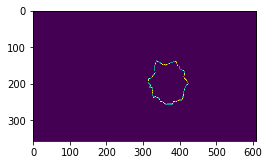

In [5]:
pylab.rcParams['figure.figsize'] = (4, 5)
imshow(segimgs[0])

# Import flow and segment images

In [6]:
data.compute_flow( flowchannel );

seg = segimgs
flow = np.swapaxes(np.swapaxes(data.flows,1,3),2,3)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  ...done!


# Dispalying Flow in X and Y for first frame 

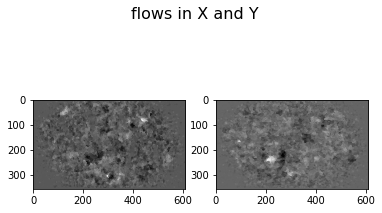

In [7]:
flow_x = np.swapaxes(flow,0,1)[0]
flow_y = np.swapaxes(flow,0,1)[1]

pylab.rcParams['figure.figsize'] = (6, 4)
fig = plt.figure()
fig.suptitle('flows in X and Y', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(flow_x[1], plt.get_cmap('gray'))
ax = fig.add_subplot(122)
ax.imshow(flow_y[1], plt.get_cmap('gray'))

## Getting boolean array of interior points

In [8]:
def compute_cell_interior(fid, oid=0):
    in_points = []
    polygon = Polygon(data.get_result_polygone_2dt(oid, fid))
    size_x, size_y = shape(flow_x[0])[0], shape(flow_x[0])[1]
    flag = numpy.full((size_x, size_y), False, dtype=bool)

    for i in range(size_x):
        for j in range(size_y):
            point = Point(j,i)
            flag[i][j] = polygon.contains(point)
            if flag[i][j]:
                in_points.append((j,i))
    return in_points, flag

## Generate Random points and recording their trajectories

In [9]:
def plot_start_end(fig, points):
    ax=fig.add_subplot(1,1,1)
    st_en = []
    ax.imshow(flag, plt.get_cmap('gray'))

    st_en.append((points[0][0], points[0][1]))
    st_en.append((points[-1][0], points[-1][1]))
                
    ax.scatter(points[0][0], points[0][1])
    ax.scatter(points[-1][0], points[-1][1], c='r', s= 40, marker= 'o' )
    
    ax.plot(*zip(*st_en))


In [10]:
def plot_trajectory(fig, points, color='#00FF00'):
    ax=fig.add_subplot(1,1,1)
    segment = []
    ax.imshow(flag, plt.get_cmap('gray'))

    for i in range(len(points)-1):
        segment.append((points[i][0], points[i][1]))
        segment.append((points[i+1][0], points[i+1][1]))
                
        if i==0:
            ax.scatter(points[i][0], points[i][1], color=color, s=20, marker= 'o')
        #ax.scatter(points[i+1][0], points[i+1][1], color=color, s=10, marker= 'x' )
        if i==len(points)-2:
            ax.scatter(points[i+1][0], points[i+1][1], c='r', s=40, marker= 'o' )
    
        ax.plot(*zip(*segment), color=color, linewidth=.5)


In [13]:
def compute_trajectories(flow_x, flow_y, rand_p, epochs=100):
    traj  = []
    for k in range(len(rand_p)):
        pos_x = in_points[rand_p[k]][1]
        pos_y = in_points[rand_p[k]][0]
        int_x = int(round(pos_x))
        int_y = int(round(pos_y))
        epoch = 0
        temp = []
        while flag[int_x][int_y] and epoch<epochs:
            int_x = int(round(pos_x))
            int_y = int(round(pos_y))
            temp.append( ( int_y, int_x ) )
            pos_x += flow_x[int_x][int_y]
            pos_y -= flow_y[int_x][int_y]
            epoch=epoch+1
        traj.append(temp)
        #plot_trajectory(fig, temp, color=col)
        plot_trajectory(fig, temp)
    return traj

frame = 33
in_points, flag = compute_cell_interior(frame)
np.random.seed(79)
rand_p = np.random.randint(0,len(in_points),20)
traj = compute_trajectories(flow_x[frame], flow_y[frame], rand_p, epochs=250)

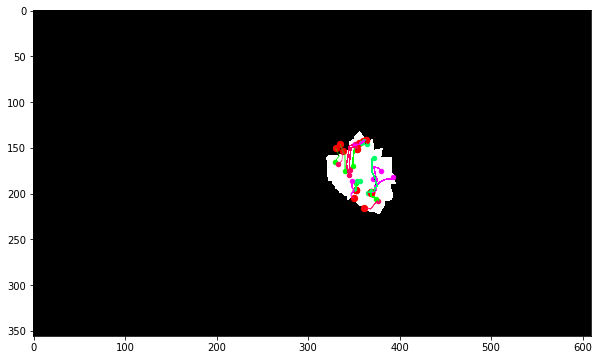

In [14]:
pylab.rcParams['figure.figsize'] = (10, 16)
fig=plt.figure()

colors=["#FF00FF", "#00FF00", "#FF0066", "#00FF66"]

for i in range(len(traj)):
    col = colors[i%len(colors)]
    plot_trajectory(fig, traj[i][:], color=col)

Checking whether interior points are correctly captured

In [15]:
avg_flow_x =  np.mean(flow_x, axis=0)
avg_flow_y =  np.mean(flow_y, axis=0)

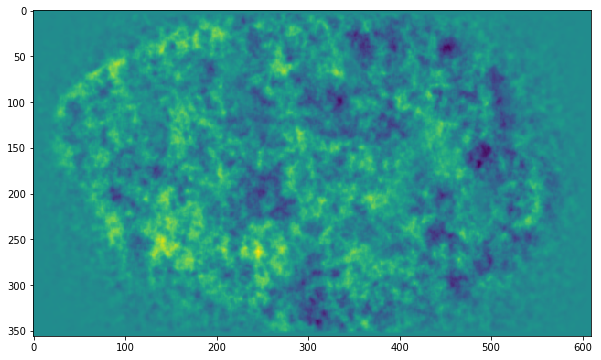

In [51]:
imshow(av_x)

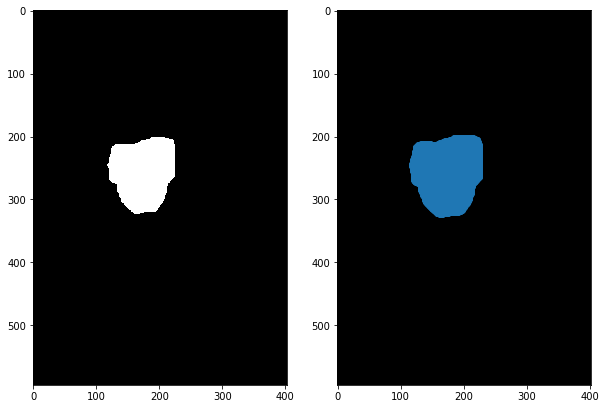

In [19]:

pylab.rcParams['figure.figsize'] = (10, 8)
fig=plt.figure()
ax=fig.add_subplot(1,2,1)
ax.imshow(flag, plt.get_cmap('gray'))

ax=fig.add_subplot(1,2,2)
ax.imshow(flag, plt.get_cmap('gray'))
ax.scatter(*zip(*in_points))

In [45]:
shape(flow_y)

(75, 356, 610)

In [46]:
av_x= np.mean(flow_x, axis=0) #av flow in x dir 
av_y = np.mean(flow_y, axis=0) #av flow in x dir

In [47]:
shape(av_x)

(356, 610)

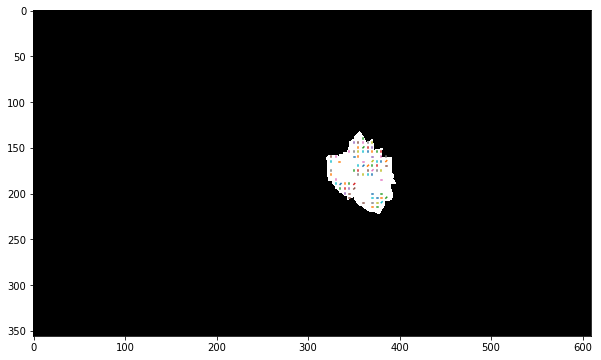

In [52]:

pylab.rcParams['figure.figsize'] = (10, 8)
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(flag, plt.get_cmap('gray'))
#ax.plot([10, 100], [10, 200])

size_x, size_y = shape(flow_x[0])[0], shape(flow_x[0])[1]
for i in xrange(0, size_x, 5 ):
    for j in xrange(0, size_y, 5):
        if flag[i][j]:
            ax.plot([j, int(round(j+av_x[i][j]))], [i, int(round(i+av_y[i][j]))])
            print 

In [54]:
for i in xrange(0, size_x, 5):
    for j in xrange(0, size_y, 5):
        if flag[i][j]:
            print av_x[i][j] , av_y[i][j]

-0.353387 -0.0468306
0.00526575 -0.243929
-0.112822 -0.590433
0.43102 -0.363963
-0.189604 -0.620571
-0.0573312 -0.556673
0.0646487 -0.694755
-0.0586378 -0.799999
-0.275945 -0.720245
-0.0142669 -0.211501
-0.362785 -0.473457
0.328627 -0.591742
0.726179 -0.900045
0.321771 -0.822536
0.174067 -0.532979
-0.274638 -0.496616
0.156898 -0.600852
-0.0138083 -0.580389
-0.00614374 -1.10678
0.0667462 -0.913219
0.442858 -0.910766
0.162759 -0.79354
-0.0592733 -0.713468
-0.113457 -0.57372
0.292284 -0.183908
-0.0346599 -0.608645
-0.200504 -1.11879
-0.457232 -0.440168
-0.268962 -0.140912
0.252306 -0.230415
0.751419 -0.335459
0.192005 -0.585526
0.177701 -0.243402
0.615083 -0.470912
0.532587 -0.438329
0.0395329 -0.471925
-0.185774 -0.724801
0.0541177 -0.795327
-0.0522612 -0.125488
-0.0389727 -0.518189
-0.481644 -0.384064
-0.757675 -0.0920781
-0.305177 -0.0592961
0.347916 -0.0233702
0.427782 0.518738
0.390657 0.157859
0.677212 -0.331542
0.572227 -0.442715
0.705362 -0.984449
0.0123186 -0.512454
-0.245847 -0.

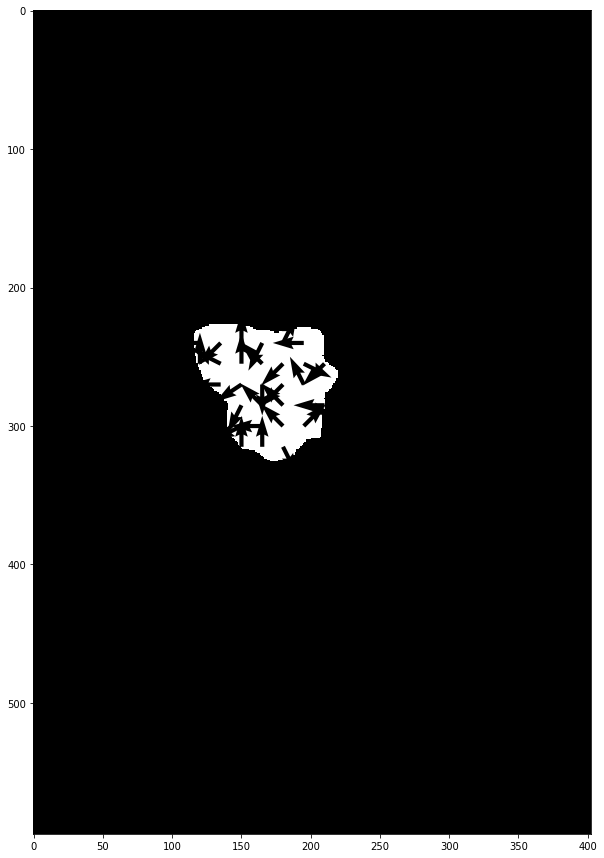

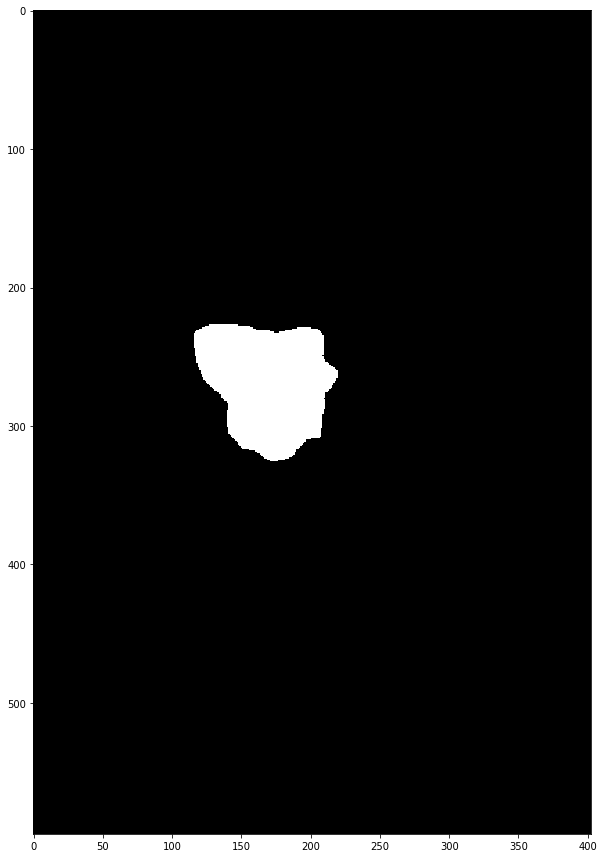

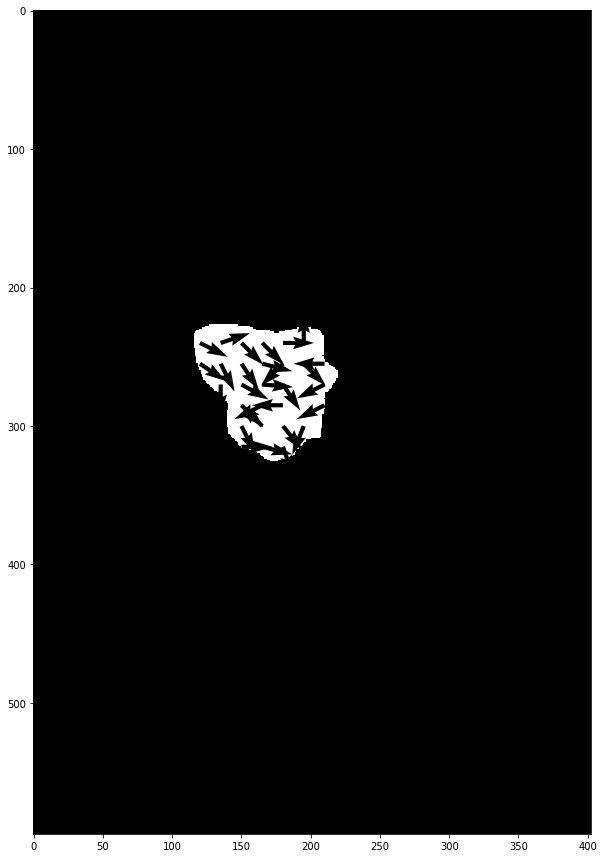

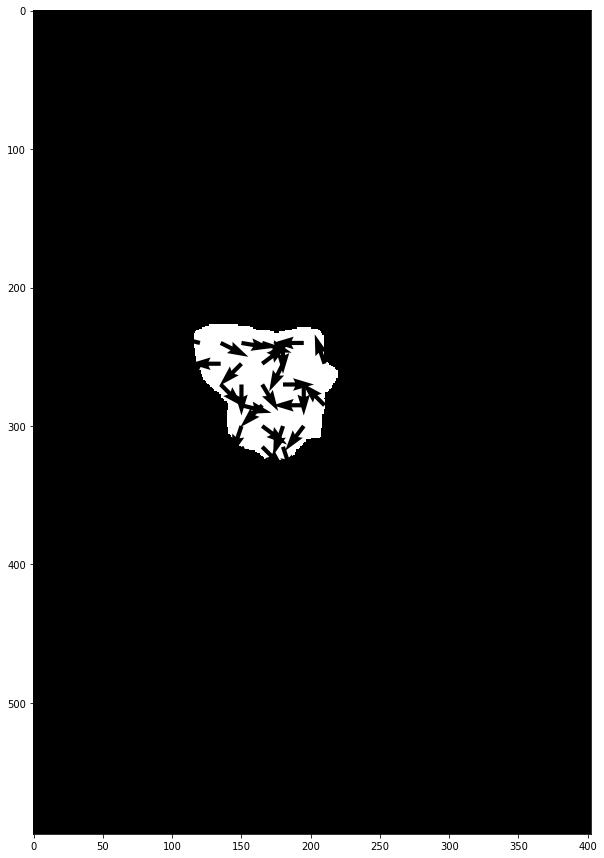

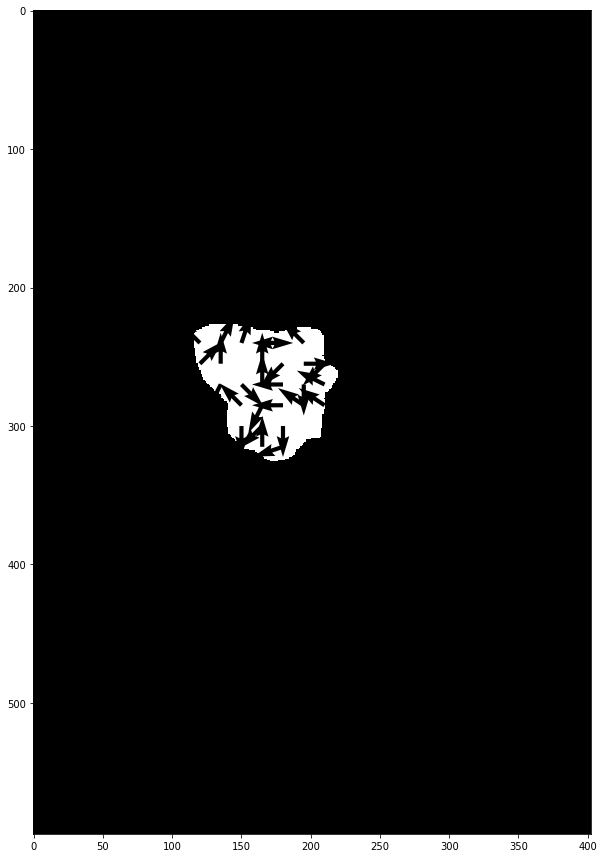

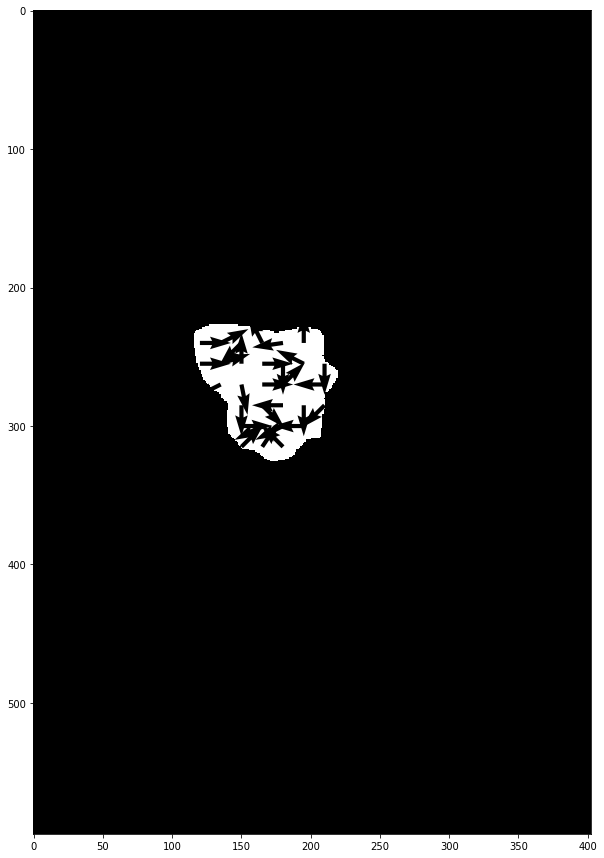

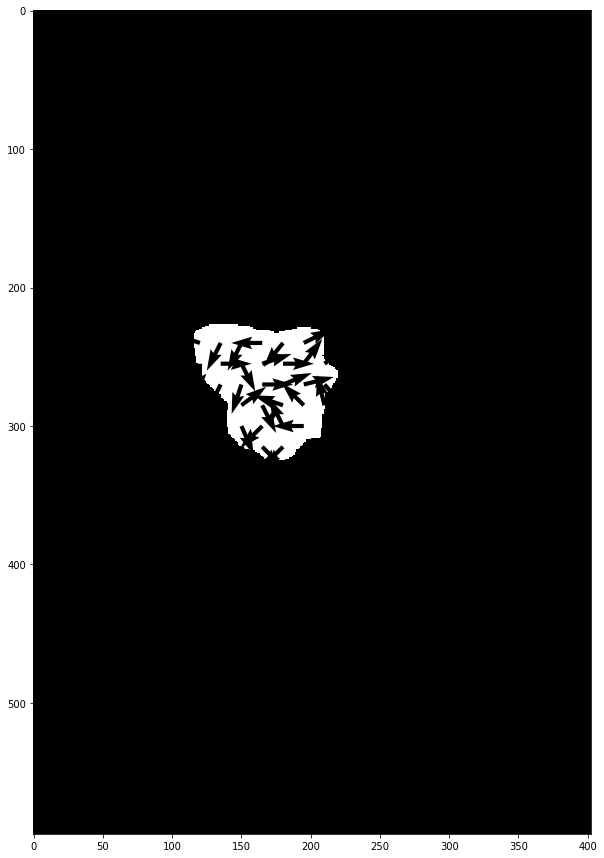

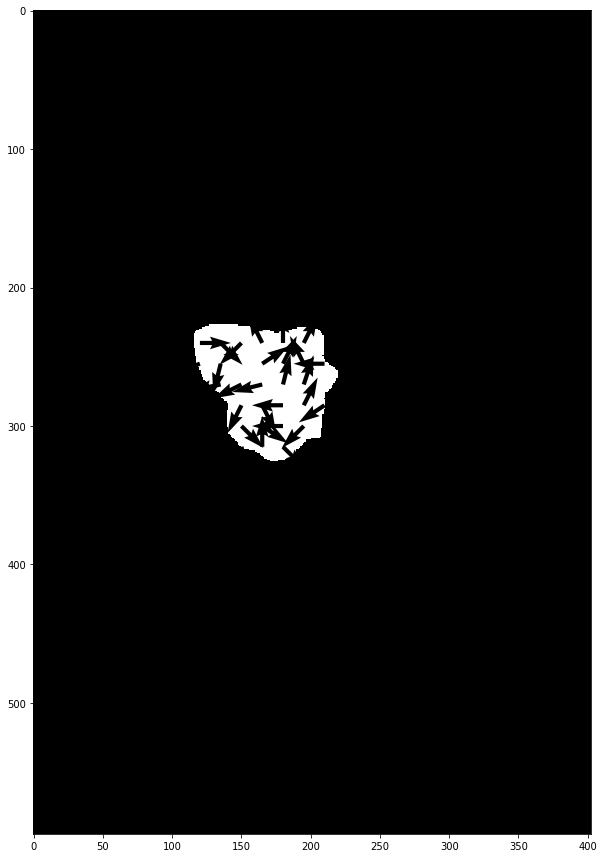

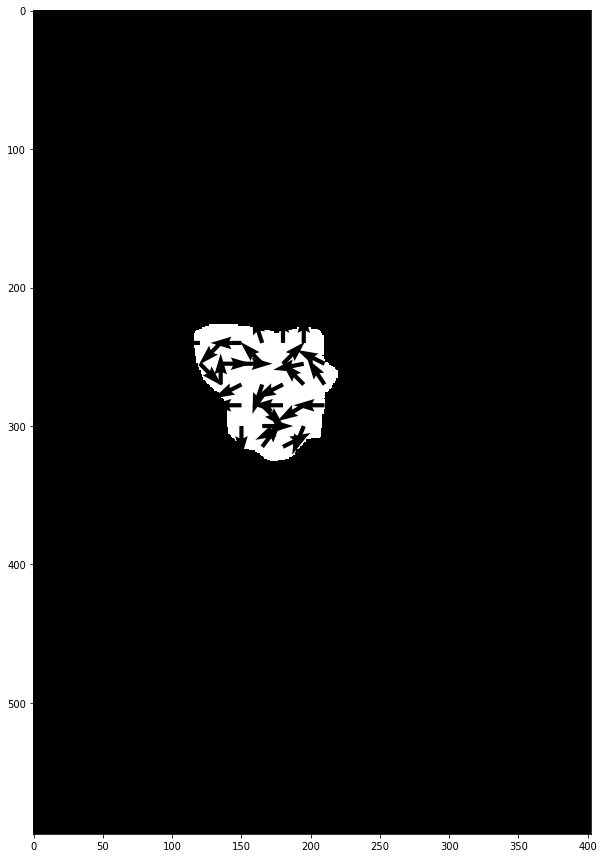

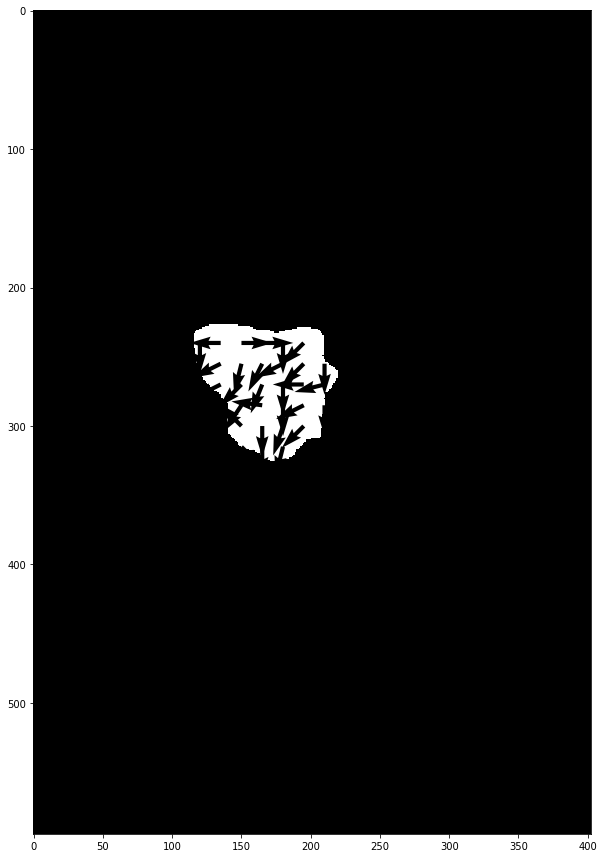

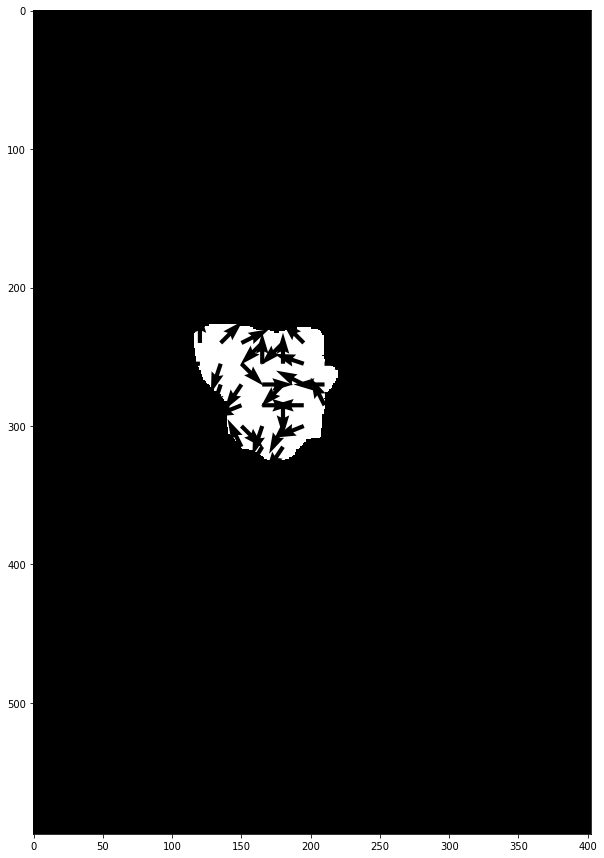

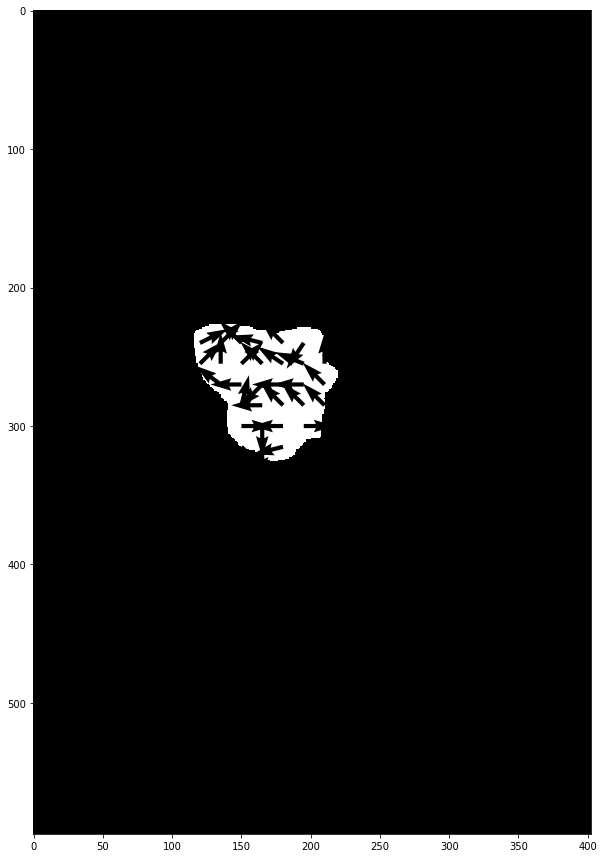

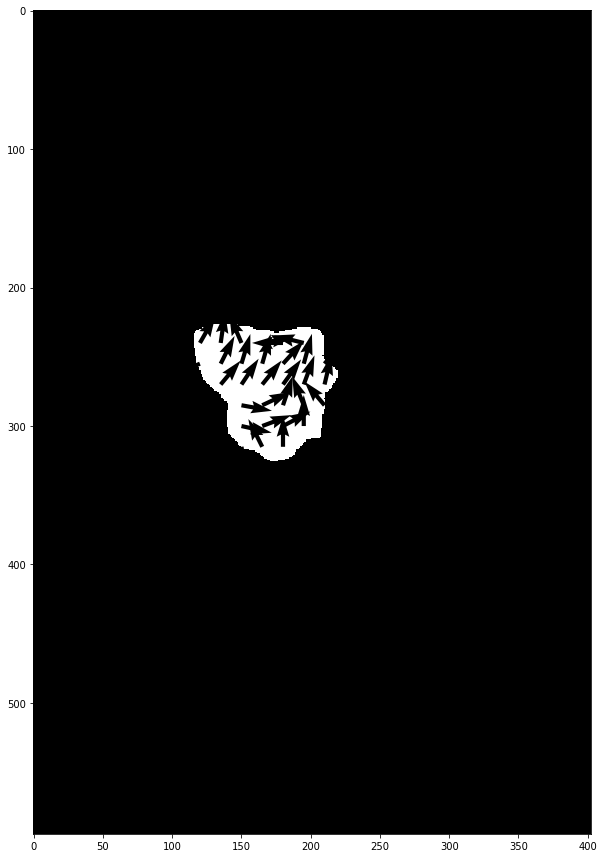

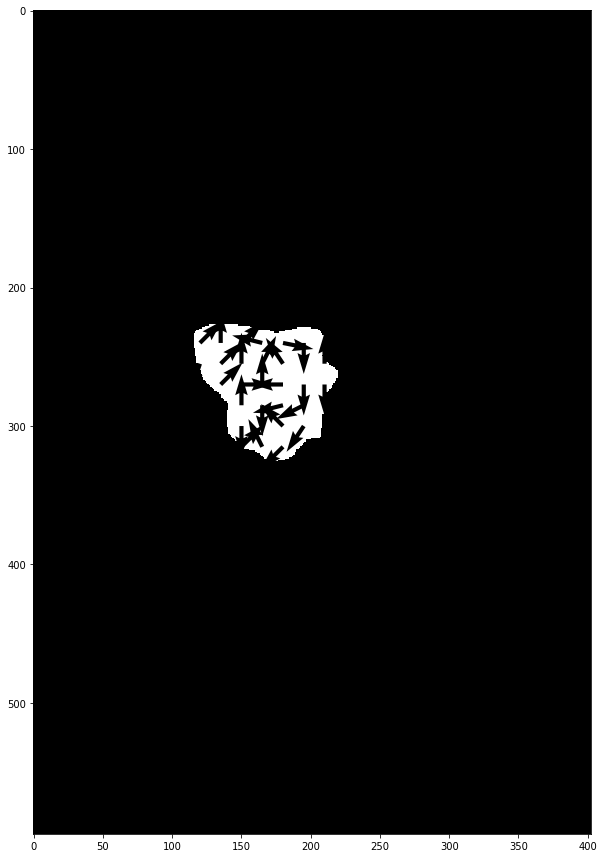

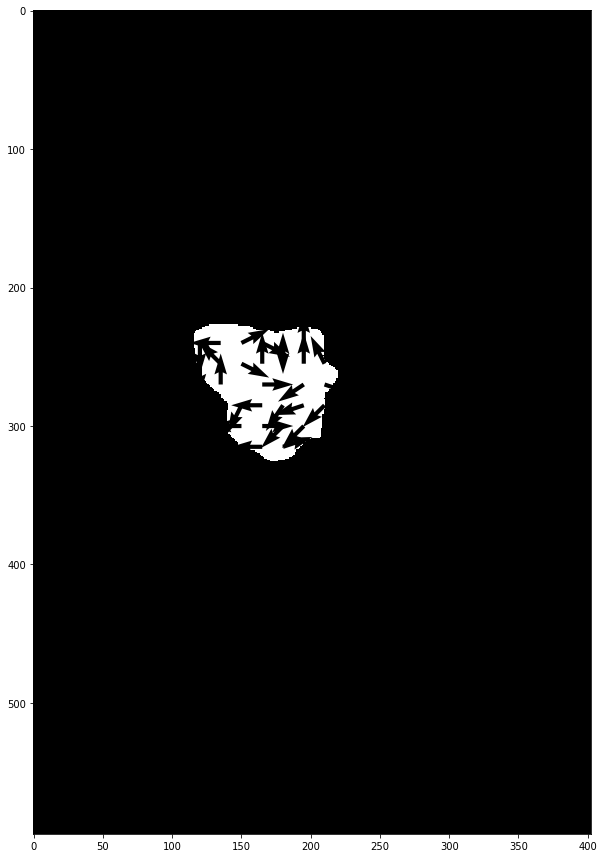

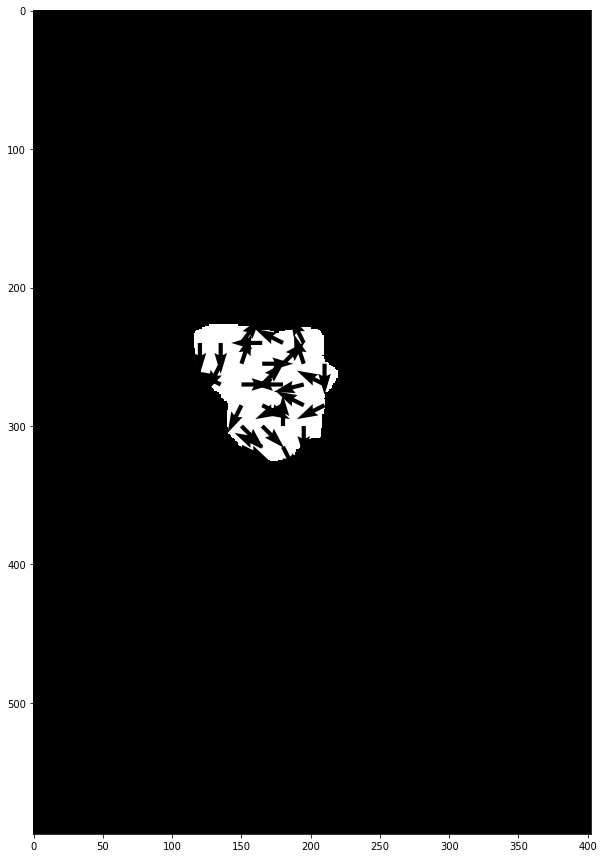

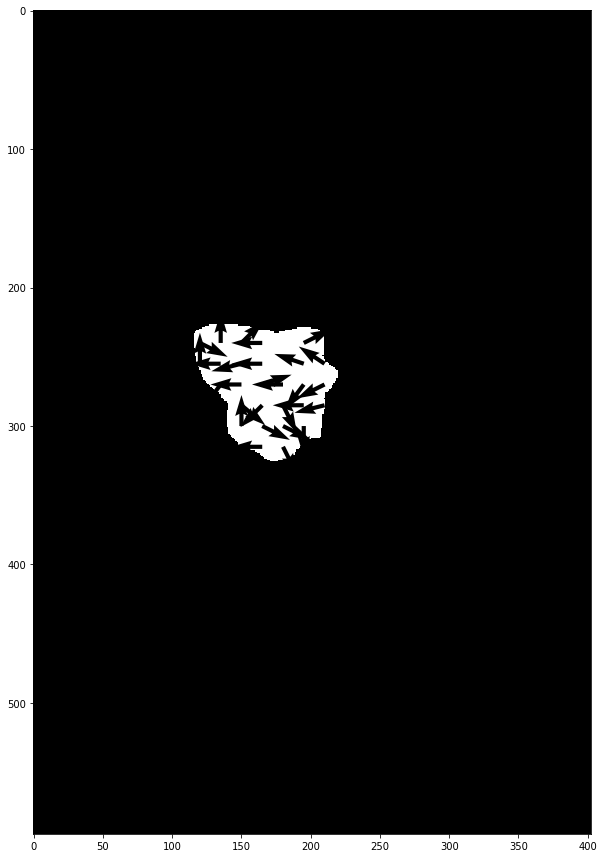

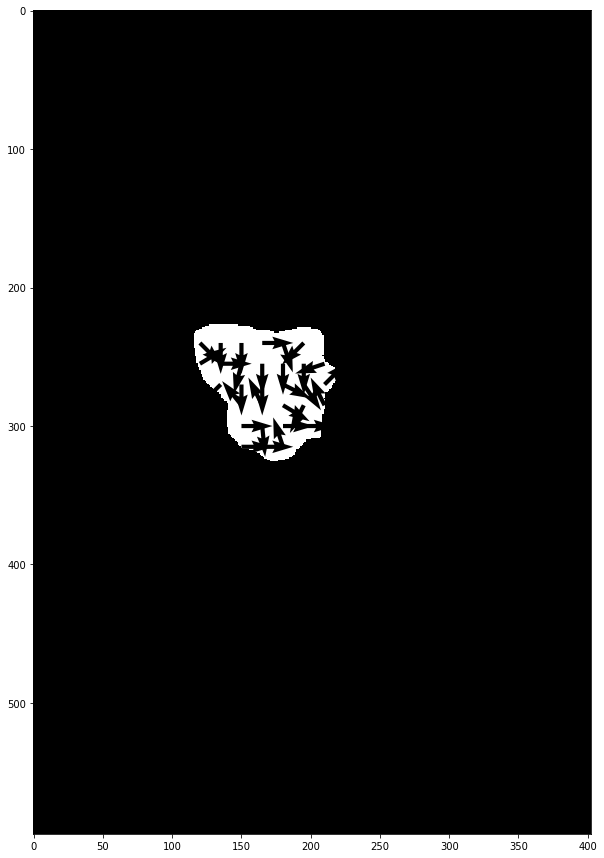

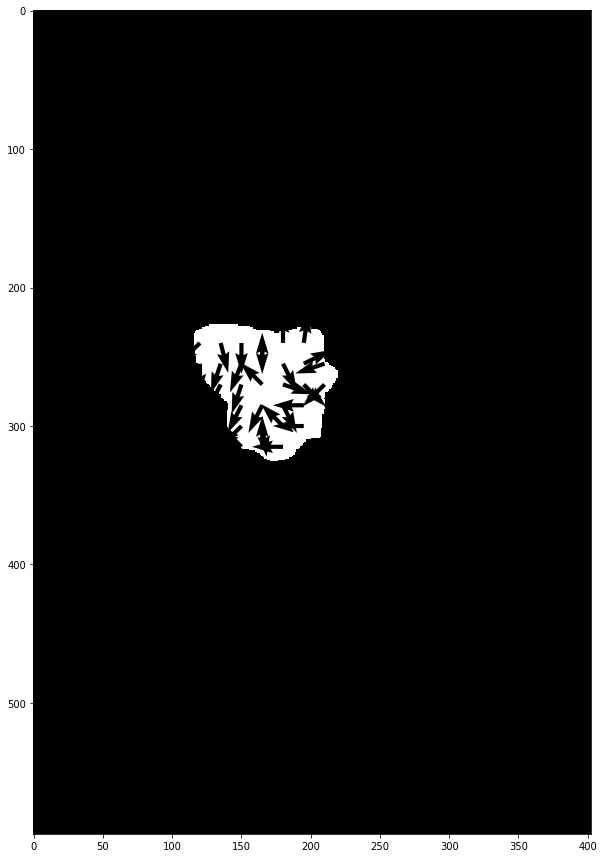

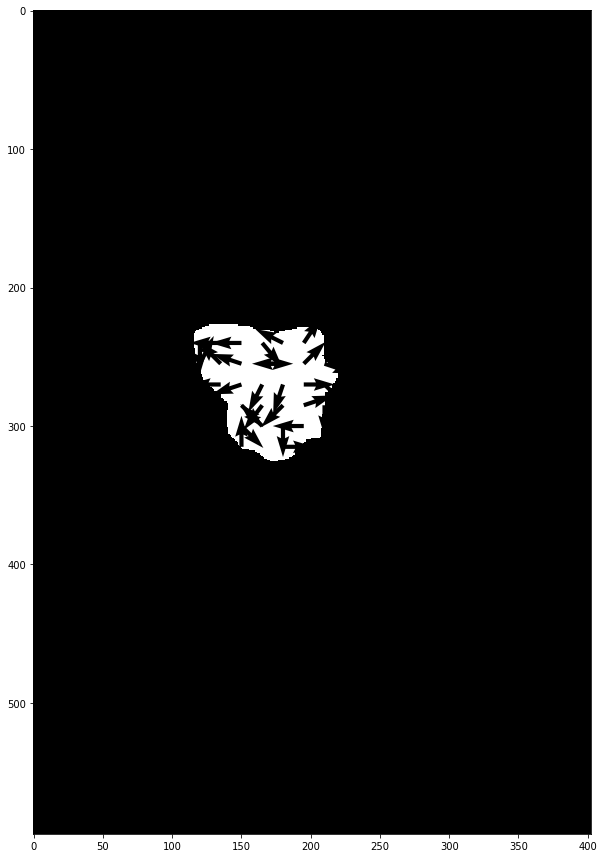

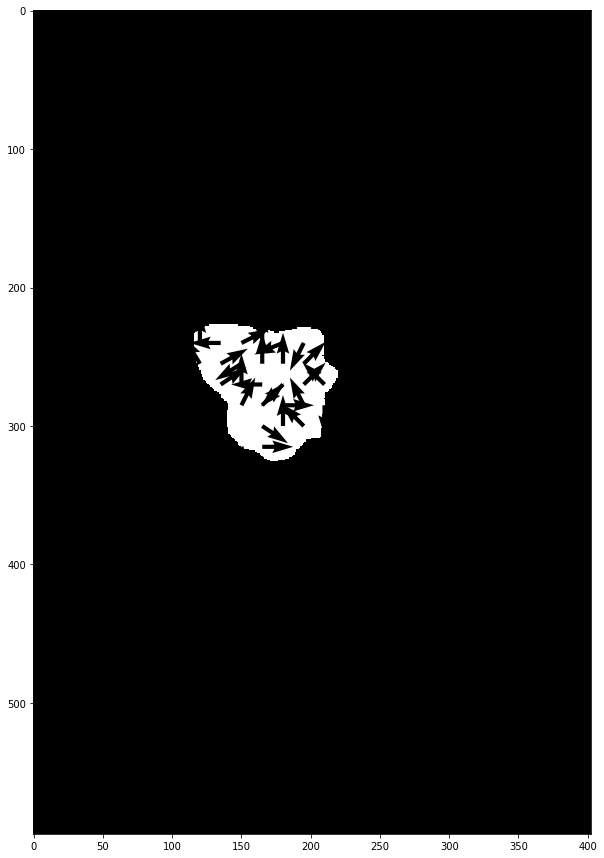

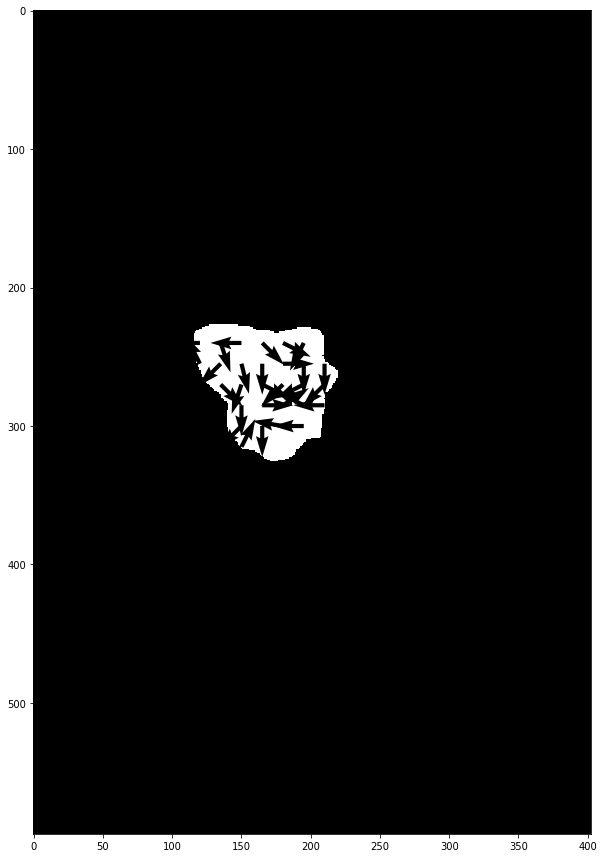

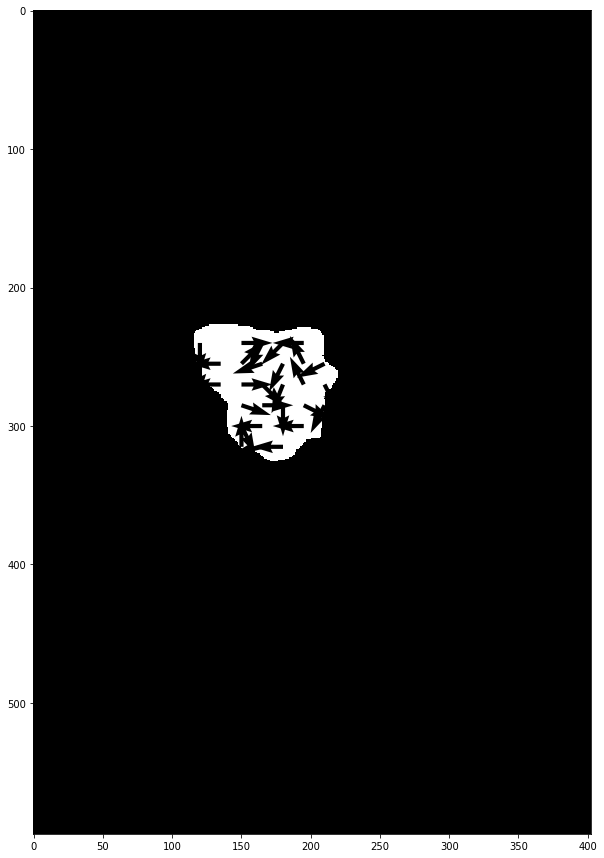

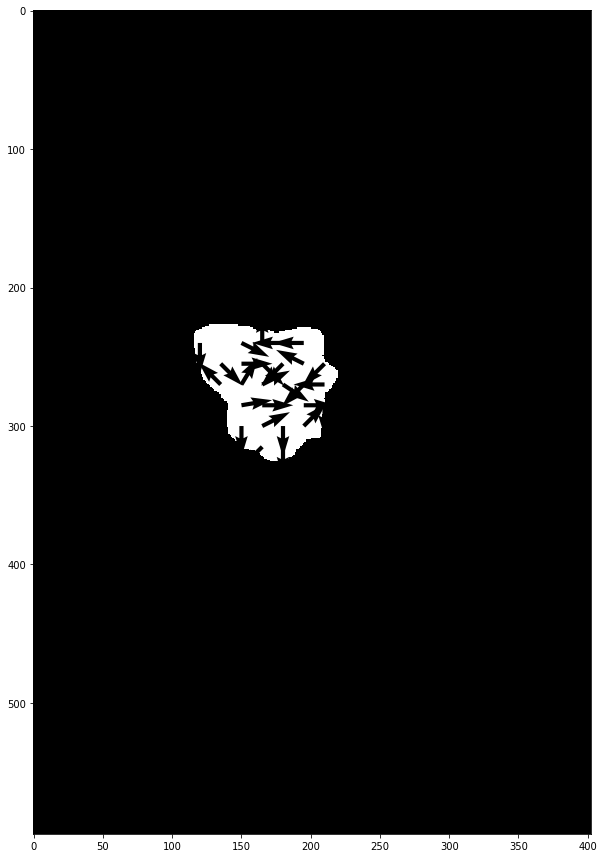

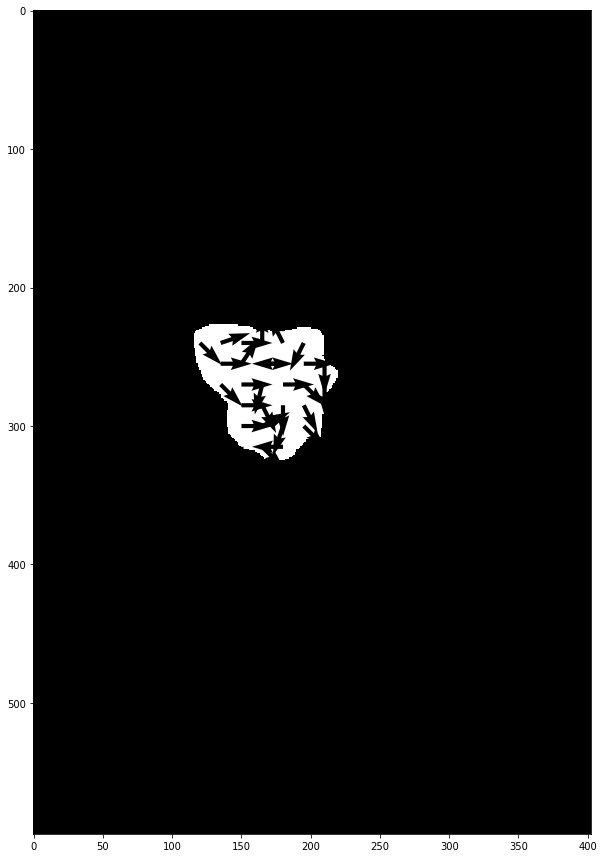

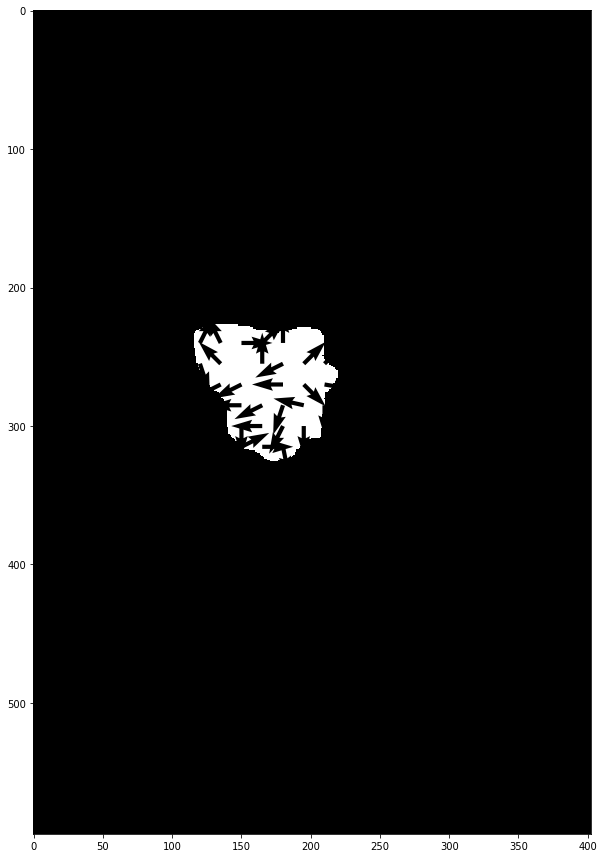

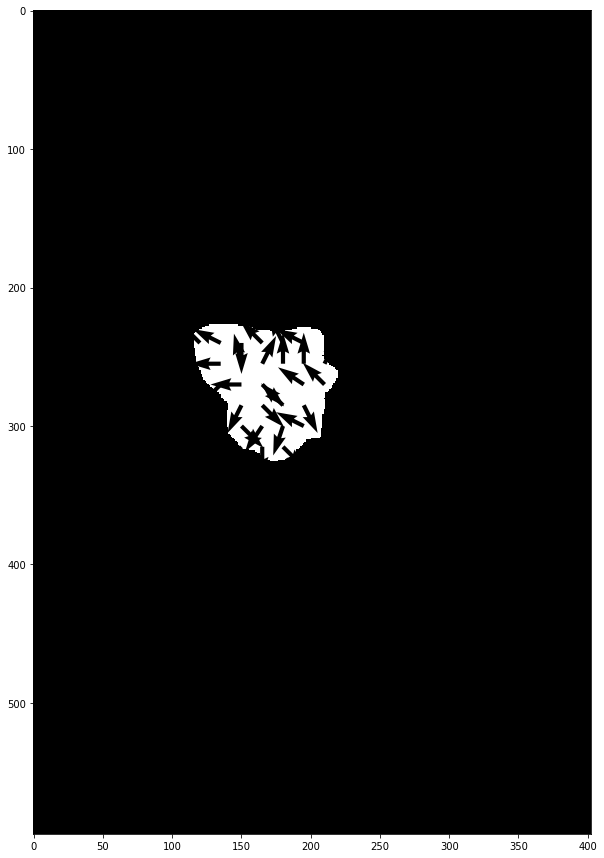

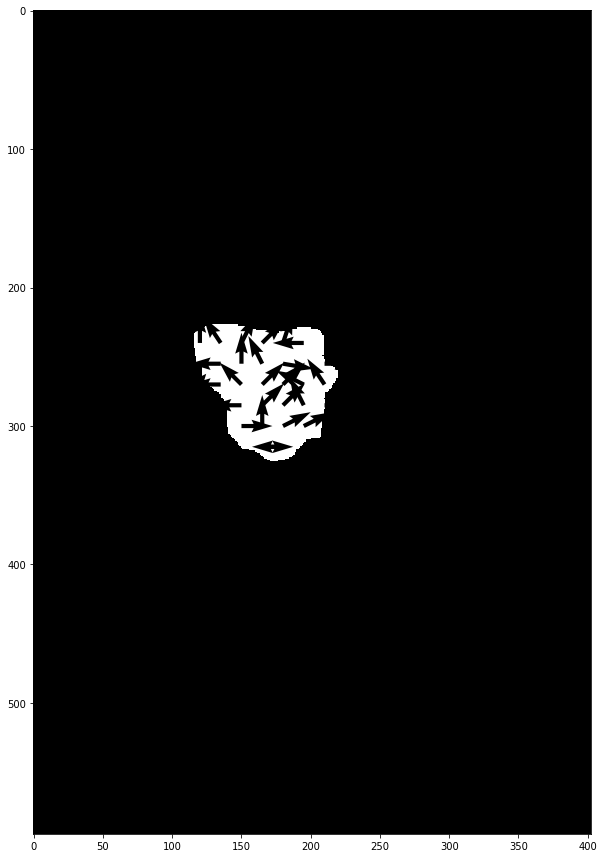

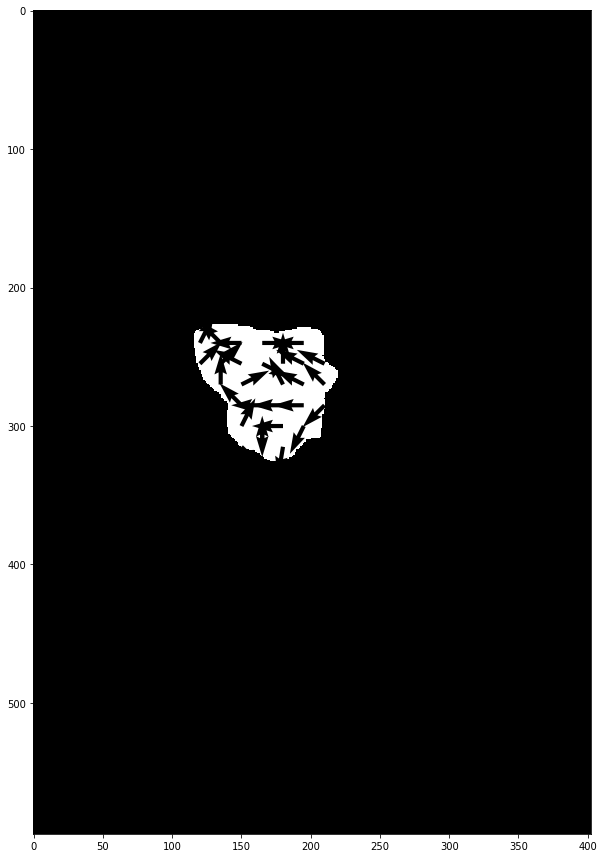

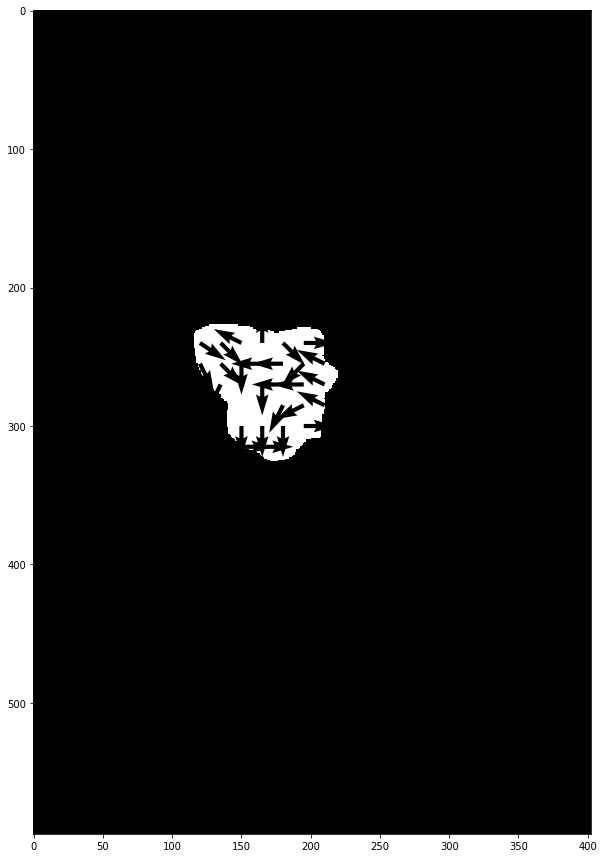

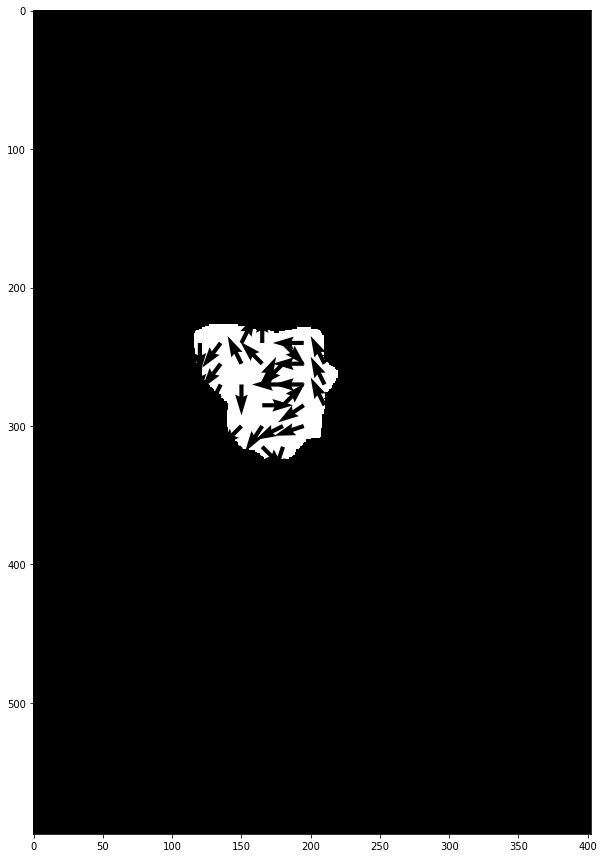

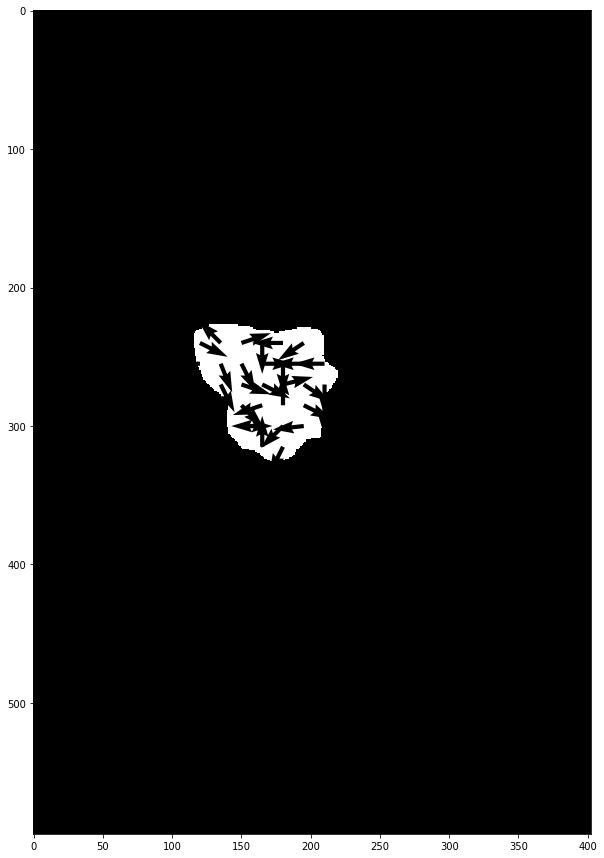

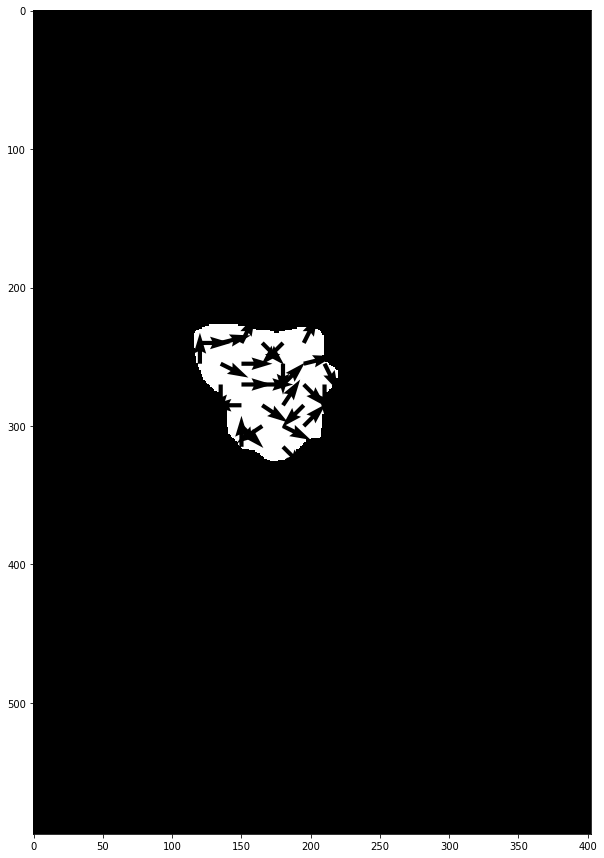

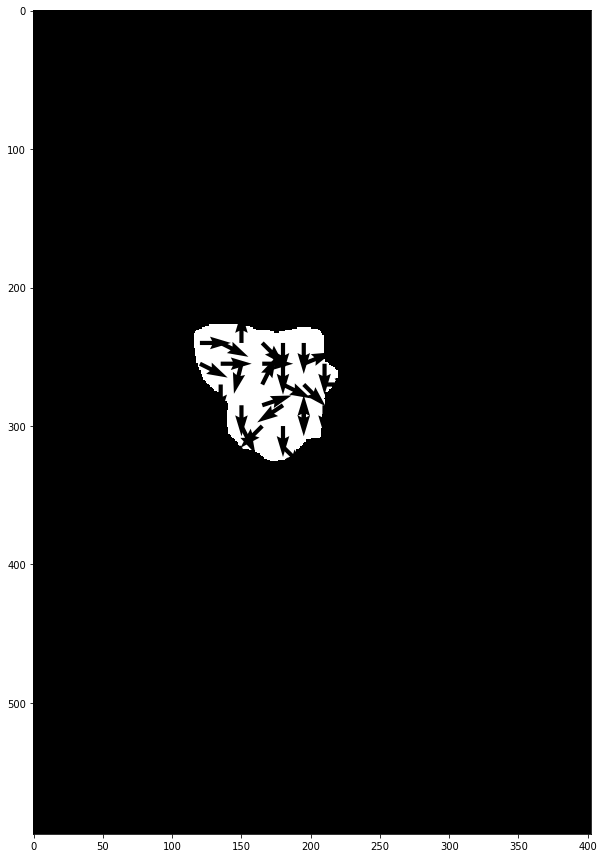

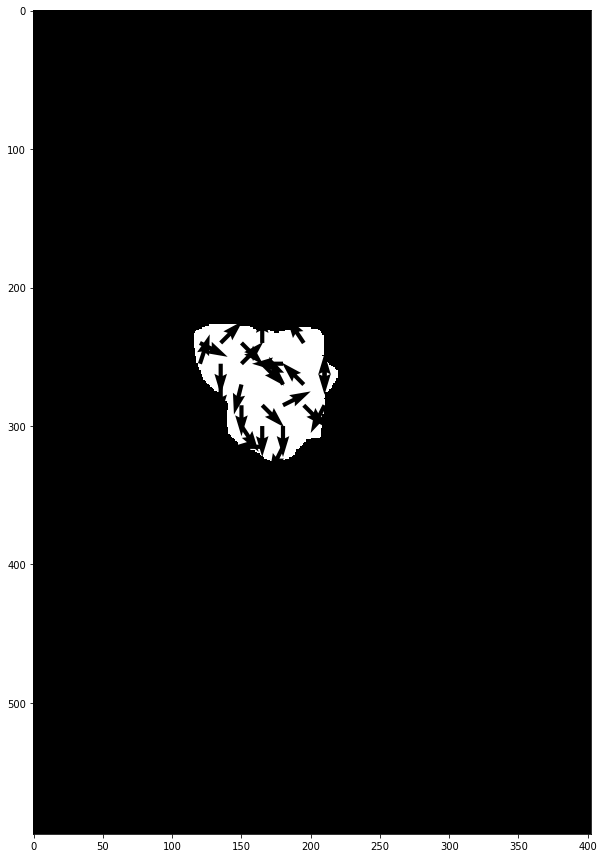

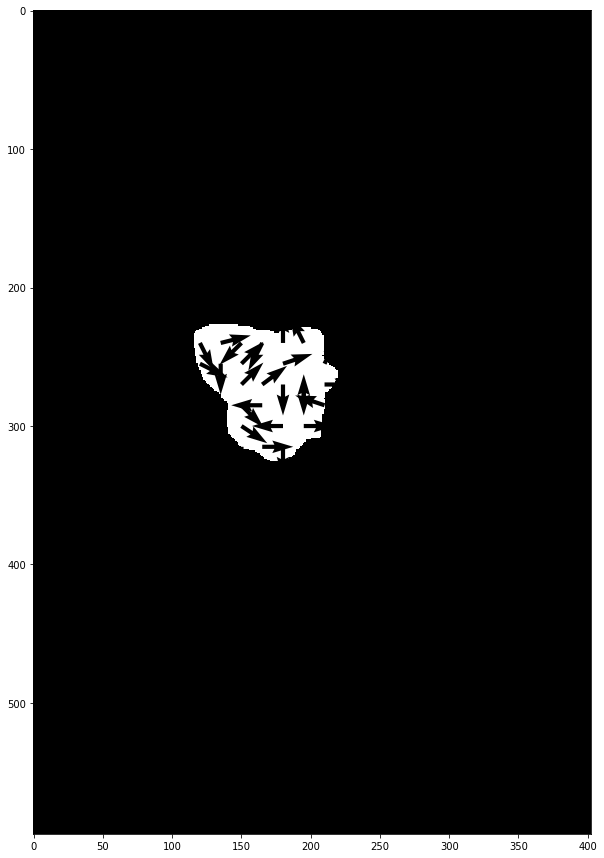

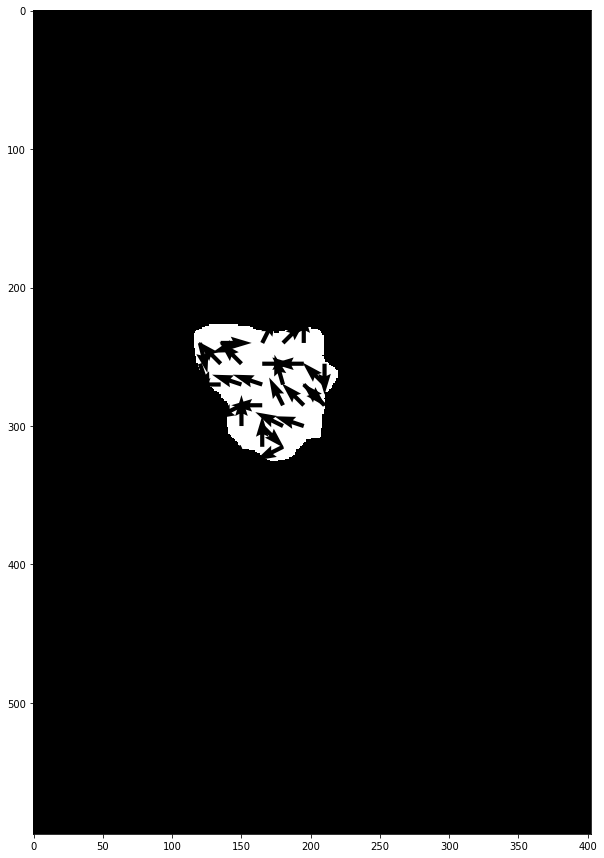

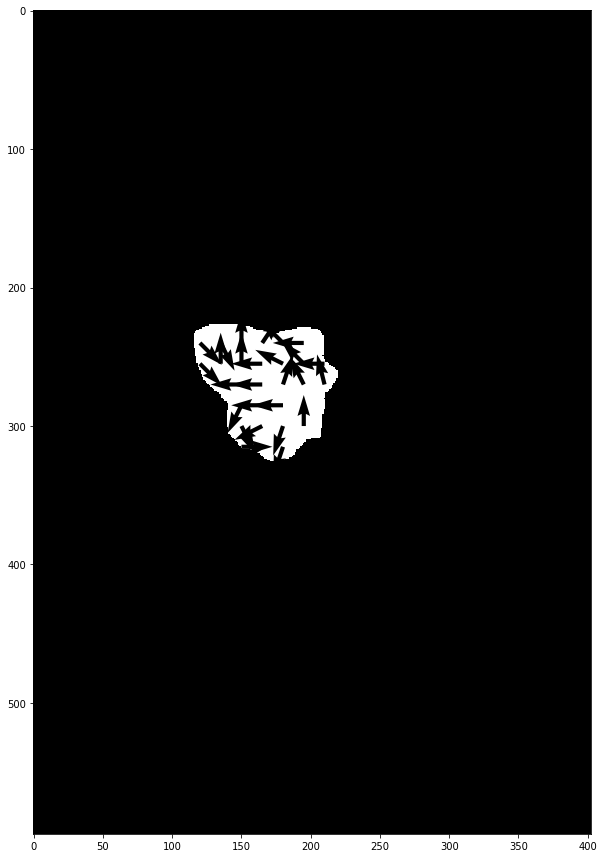

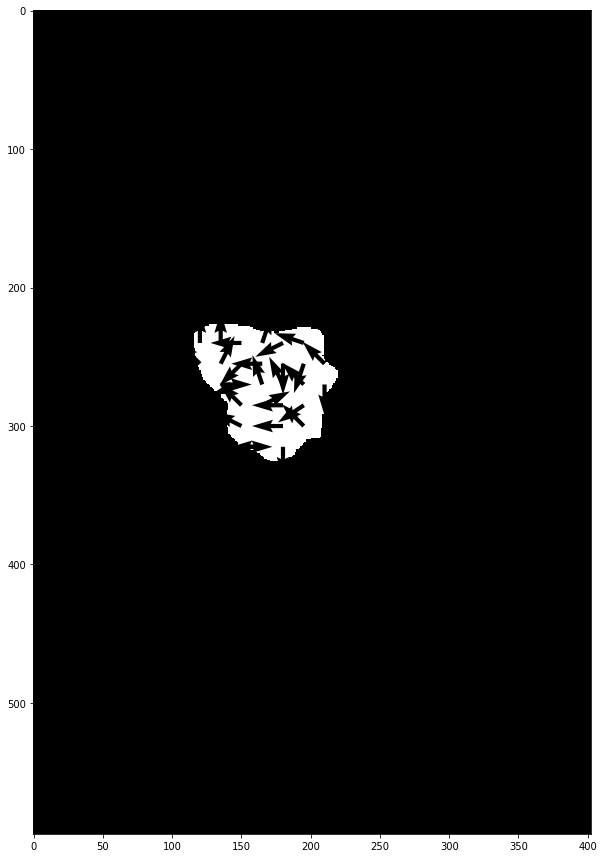

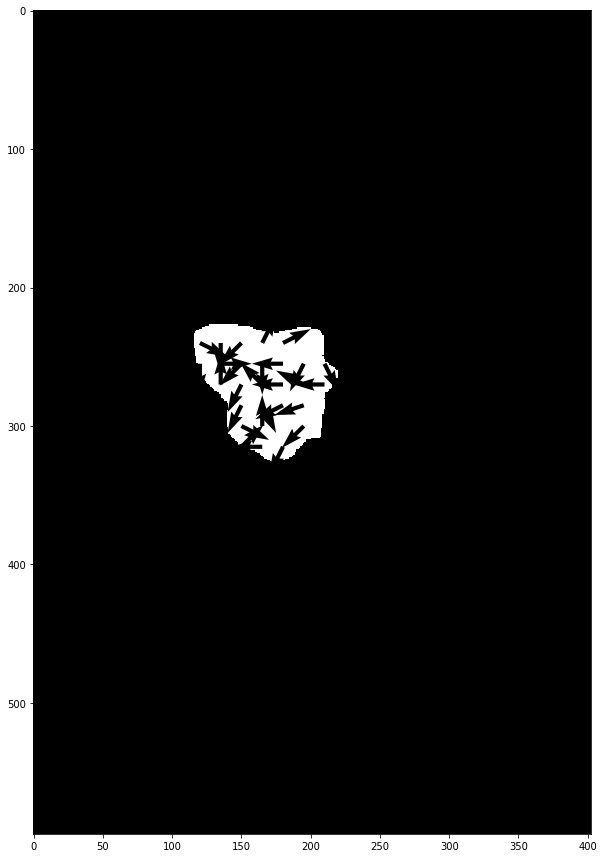

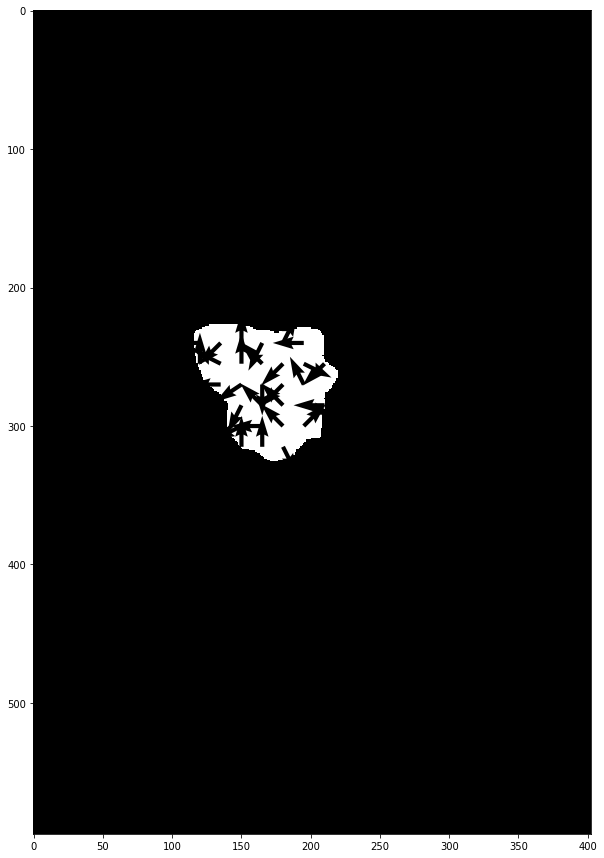

In [97]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

def draw_flow(flow_x, flow_y, frame):
    pylab.rcParams['figure.figsize'] = (10, 16)
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.imshow(flag, plt.get_cmap('gray'))
    size_x, size_y = shape(flow_x[0])[0], shape(flow_x[0])[1]
    for i in xrange(0, size_x, 15):
        for j in xrange(0, size_y, 15):
            if flag[i][j]:
                ax.quiver(j, i, int(round((flow_y[frame][i][j]))), int (round(flow_y[frame][i][j])))
for i in range(40):
    draw_flow(flow_x, flow_y, i)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)


In [17]:
def plot_flow(img, flag, fx, fy):
    ax.imshow(img, plt.get_cmap('gray'))
    size_x, size_y = shape(flow_x[0])[0], shape(flow_x[0])[1]
    for i in xrange(0, size_x, 5 ):
        for j in xrange(0, size_y, 5):
            if flag[i][j]:
                ax.quiver(j, i, int(round(fy[i][j])), int(round(fx[i][j])), 
                          angles='xy', scale_units='xy', scale=.25, width=0.001, color='r')
        

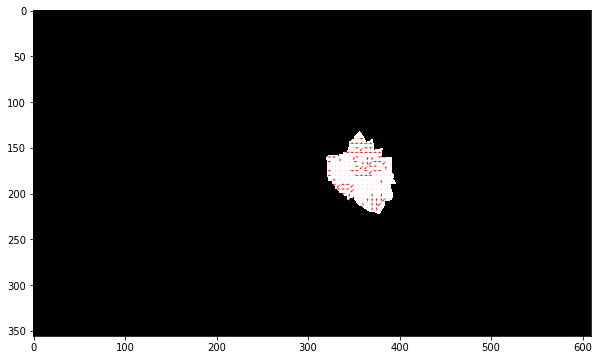

In [50]:
pylab.rcParams['figure.figsize'] = (10, 8)
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
f=7
#plot_flow(flag,flag,flow_x[f], flow_y[f])
plot_flow(flag,flag,av_x, av_y)

In [20]:
size_y

403

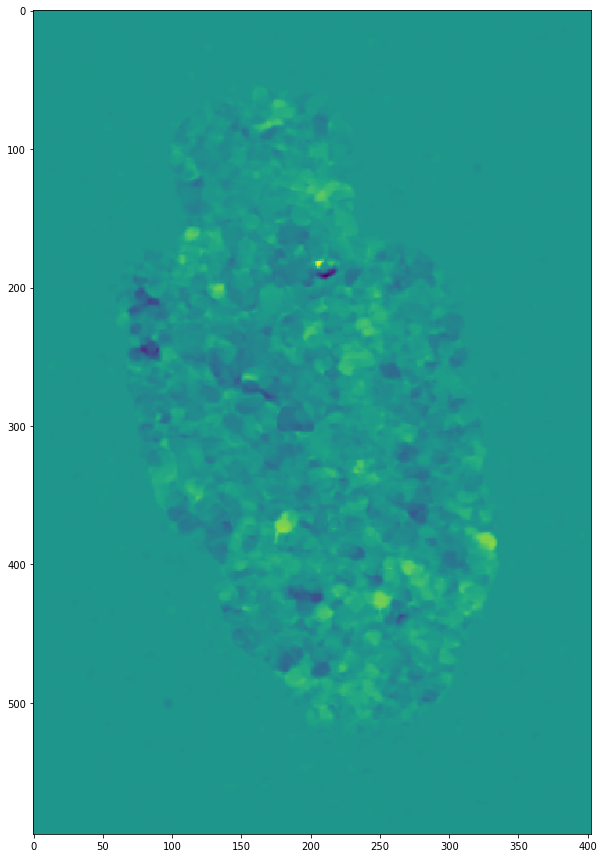

In [23]:
imshow(flow[1])

In [36]:
flag

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [41]:
a = np.array([[[2,2,3], [1,2,3]],[[1,2,3], [1,2,3]]])


In [42]:
a


array([[[2, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3]]])

In [40]:
shape(a)

(2, 2, 3)

In [43]:
np.mean(a, axis=0)

array([[ 1.5,  2. ,  3. ],
       [ 1. ,  2. ,  3. ]])